In [ ]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 20.3 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
# Import VIX Data
vix = pd.read_csv('/content/VIX_History.csv')
vix['DATE'] = pd.to_datetime(vix['DATE'])

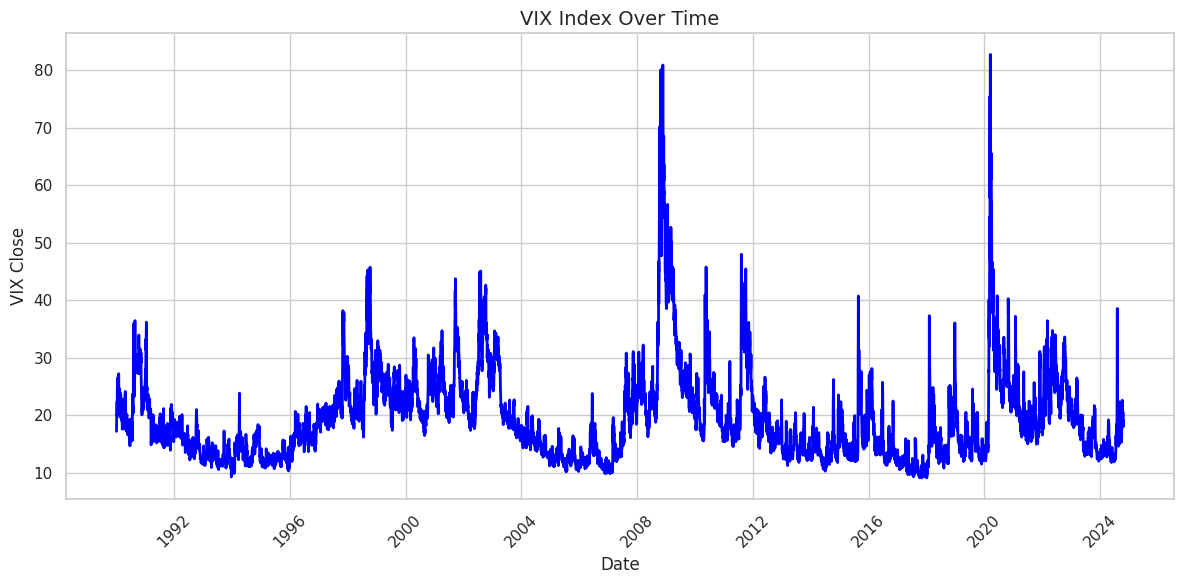

In [ ]:
# Assuming vix is your dataframe with 'DATE' and 'CLOSE' columns
sns.set_theme(style="whitegrid")  # Apply a clean theme

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='DATE', y='CLOSE', data=vix, color="blue", linewidth=2)

# Improve x-axis date formatting
plt.xlabel("Date", fontsize=12)
plt.ylabel("VIX Close", fontsize=12)
plt.title("VIX Index Over Time", fontsize=14)

# Rotate date labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

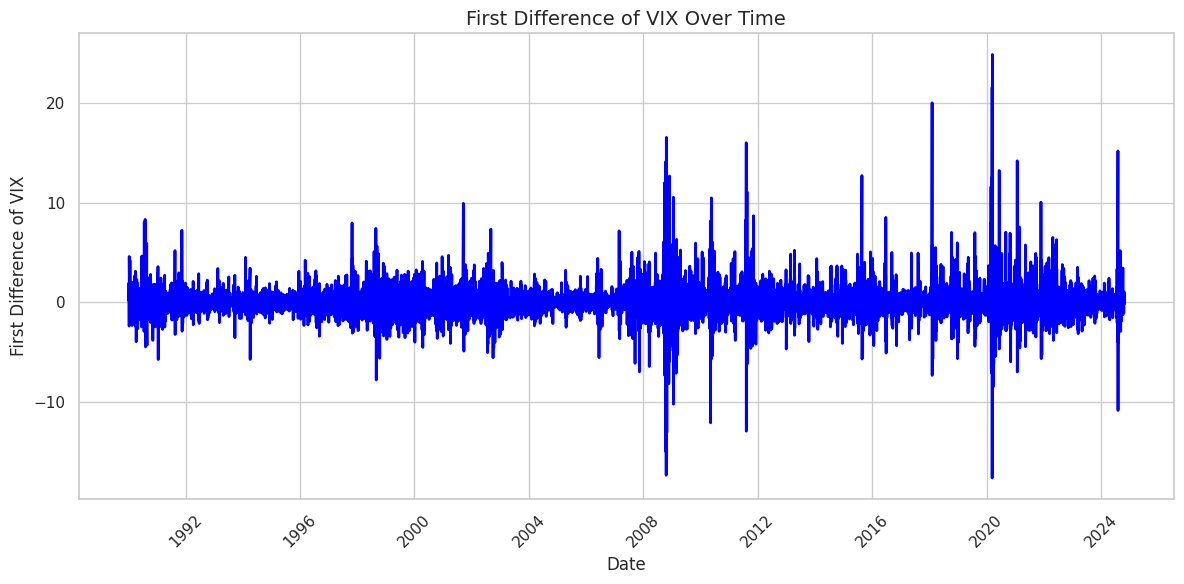

In [ ]:
# Assuming 'vix' DataFrame has 'DATE' and 'CLOSE' columns
vix['First_Difference'] = vix['CLOSE'].diff()  # Calculate first difference

# Plot the first difference using seaborn
sns.set_theme(style="whitegrid")  # Set a clean theme

plt.figure(figsize=(12, 6))
sns.lineplot(x='DATE', y='First_Difference', data=vix, color="blue", linewidth=2)

# Add labels and title
plt.xlabel("Date", fontsize=12)
plt.ylabel("First Difference of VIX", fontsize=12)
plt.title("First Difference of VIX Over Time", fontsize=14)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

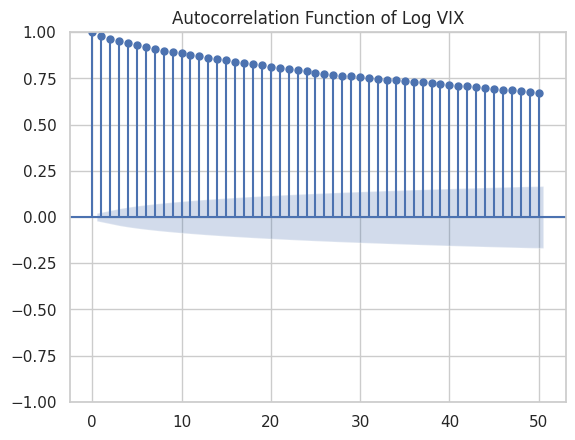

<Figure size 1200x600 with 0 Axes>

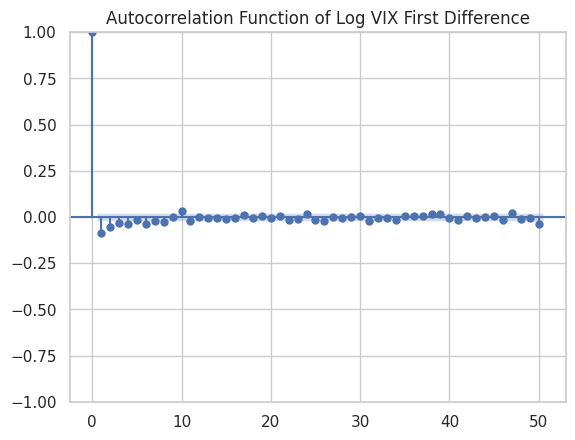

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
# Assuming 'vix' DataFrame has 'DATE' and 'CLOSE' columns
# Calculate Log VIX
vix['Log_VIX'] = np.log(vix['CLOSE'])

# Calculate First Difference of Log VIX
vix['Log_VIX_First_Diff'] = vix['Log_VIX'].diff()

# Drop NaN values caused by differencing
vix_clean = vix.dropna(subset=['Log_VIX', 'Log_VIX_First_Diff'])

# Plot ACF for Log VIX
plt.figure(figsize=(12, 6))
plot_acf(vix_clean['Log_VIX'], lags=50, title="Autocorrelation Function of Log VIX")
plt.show()

# Plot ACF for First Difference of Log VIX
plt.figure(figsize=(12, 6))
plot_acf(vix_clean['Log_VIX_First_Diff'], lags=50, title="Autocorrelation Function of Log VIX First Difference")
plt.show()

In [ ]:
# Step 2: Calculate daily realized volatility (RV) directly from VIX values (since VIX is volatility)
vix.set_index('DATE', inplace=True)
vix['VIX'] = np.log(vix['CLOSE'])  # Use VIX values directly as realized volatility (VIX is already volatility)

# Step 3: Calculate HAR-RV components (daily, weekly, and monthly realized volatilities)
vix['VIXR'] = vix['VIX']  # Daily realized volatility (1-day VIX)
vix['VIX_d'] = vix['VIX'].shift(1)
vix['VIX_w'] = vix['VIX'].rolling(window=5).mean().shift(1)  # Weekly realized volatility (average over past 5 days)
vix['VIX_m'] = vix['VIX'].rolling(window=22).mean().shift(1)  # Monthly realized volatility (average over past 22 days)

In [ ]:
vix.head()

,OPEN,HIGH,LOW,CLOSE,First_Difference,Log_VIX,Log_VIX_First_Diff,VIX,VIXR,VIX_d,VIX_w,VIX_m
DATE,,,,,,,,,,,,
1990-01-02,17.24,17.24,17.24,17.24,NaN,2.847232,NaN,2.847232,2.847232,NaN,NaN,NaN
1990-01-03,18.19,18.19,18.19,18.19,0.95,2.900872,0.053640,2.900872,2.900872,2.847232,NaN,NaN
1990-01-04,19.22,19.22,19.22,19.22,1.03,2.955951,0.055079,2.955951,2.955951,2.900872,NaN,NaN
1990-01-05,20.11,20.11,20.11,20.11,0.89,3.001217,0.045266,3.001217,3.001217,2.955951,NaN,NaN
1990-01-08,20.26,20.26,20.26,20.26,0.15,3.008648,0.007431,3.008648,3.008648,3.001217,NaN,NaN


In [ ]:
vix.shape

(8785, 12)

In [ ]:
data = pd.DataFrame({
    'VIXR_D': vix['VIX_d'],
    'VIXR_W': vix['VIX_w'],
    'VIXR_M': vix['VIX_m']
}).dropna()
data = data.dropna()
data.tail()

,VIXR_D,VIXR_W,VIXR_M
DATE,,,
2024-10-18,2.950212,2.990208,2.917253
2024-10-21,2.892037,2.964921,2.916751
2024-10-22,2.910719,2.950941,2.922102
2024-10-23,2.901422,2.925780,2.927534
2024-10-24,2.956991,2.922276,2.936229


In [ ]:
data.shape

(8763, 3)

In [ ]:
X = data[['VIXR_D','VIXR_W','VIXR_M']]  # Independent variables: daily, weekly, and monthly RV
y = vix['VIX']  # Dependent variable: future realized volatility (VIX in our case)

# Drop rows with NaN (due to shifting)
X = X.dropna()
y = y.dropna()

# Ensure X and y are aligned
X, y = X.align(y, join='inner', axis=0)

In [ ]:
row_number = data.index.get_loc('2019-12-31')
print(row_number)

7532


In [ ]:
# Step 6: Time series split with purging
split_index = 8600  # Split 80% for in-sample (training) and 20% for out-sample (testing)
purge_window = 50  # Purging window of 20 days to avoid data leakage between train and test sets

# In-Sample (Training Data) - First 80% of the dataset
X_train = X[:split_index]
y_train = y[:split_index]

# Out-Sample (Testing Data) - Last 20% of the dataset after purging window
X_test = X[split_index + purge_window:]
y_test = y[split_index + purge_window:]


In [ ]:
# Step 7: Add a constant term to the independent variables (for OLS regression)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [ ]:
def qlike(actual, predicted):
    return np.sum((actual / predicted) - np.log(actual / predicted) - 1)

### The Autoregressive Model (Benchmarket)

In [ ]:

# Fit the AR(1) model
ar1_model = sm.OLS(y_train, X_train).fit()

# Step 2: Predict on training and testing sets
y_train_pred = ar1_model.predict(X_train)
y_test_pred = ar1_model.predict(X_test)

# Step 3: In-Sample MSE
mse_in_sample = mean_squared_error(y_train, y_train_pred)
print("In-Sample Mean Squared Error (MSE):", mse_in_sample)

# Step 4: Out-of-Sample MSE (already provided)
mse_out_sample = mean_squared_error(y_test, y_test_pred)
print("Out-of-Sample Mean Squared Error (MSE):", mse_out_sample)

qlike_in_sample = qlike(y_train, y_train_pred)
print("In-Sample QLIKE:", qlike_in_sample)

qlike_out_sample = qlike(y_test, y_test_pred)
print("Out-of-Sample QLIKE:", qlike_out_sample)

# Print model summary
print(ar1_model.summary())

In-Sample Mean Squared Error (MSE): 0.0044125169529841465
Out-of-Sample Mean Squared Error (MSE): 0.008245601781464001
In-Sample QLIKE: 2.1850597016896467
Out-of-Sample QLIKE: 0.05098110955295865
                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                 2.263e+05
Date:                Sun, 01 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:37:45   Log-Likelihood:                 11117.
No. Observations:                8600   AIC:                        -2.223e+04
Df Residuals:                    8598   BIC:                        -2.222e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
              

In [ ]:
y_test.shape

(113,)

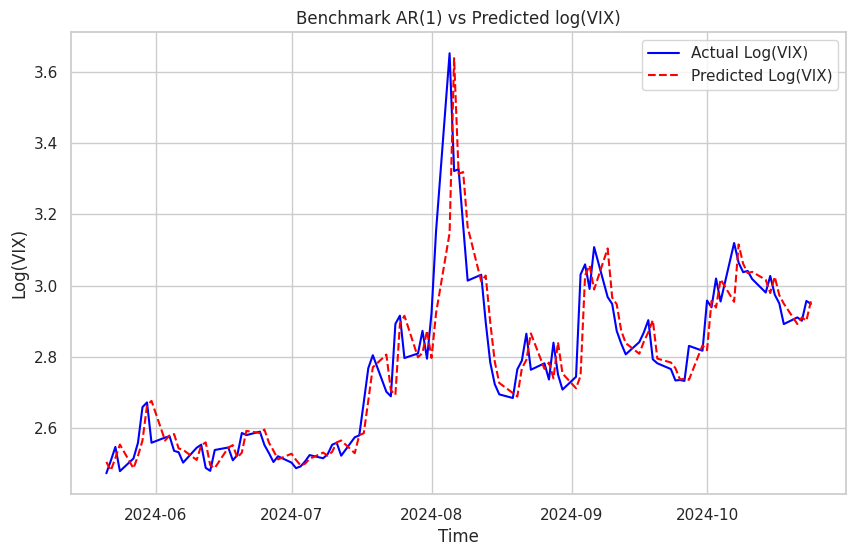

In [ ]:
y_pred = ar1_model.predict(X_test)

# Residuals
residuals = y_test - y_pred

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.index,  y_test, label='Actual Log(VIX)', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Log(VIX)', color='red', linestyle='--')
plt.title('Benchmark AR(1) vs Predicted log(VIX)')
plt.xlabel('Time')
plt.ylabel('Log(VIX)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_pred.shape

(113,)

### Heterogeneous Autoregressive Model

In [ ]:
# Step 8: Train the HAR-RV model on in-sample data
har_model = sm.OLS(y_train, X_train).fit()

# Step 2: Predict on training and testing sets
y_train_pred = har_model.predict(X_train)
y_test_pred = har_model.predict(X_test)

# Step 3: In-Sample MSE
mse_in_sample = mean_squared_error(y_train, y_train_pred)
print("In-Sample Mean Squared Error (MSE):", mse_in_sample)

# Step 4: Out-of-Sample MSE (already provided)
mse_out_sample = mean_squared_error(y_test, y_test_pred)
print("Out-of-Sample Mean Squared Error (MSE):", mse_out_sample)

# Step 6: Compute In-Sample QLIKE
qlike_in_sample = qlike(y_train, y_train_pred)
print("In-Sample QLIKE:", qlike_in_sample)

# Step 7: Compute Out-of-Sample QLIKE
qlike_out_sample = qlike(y_test, y_test_pred)
print("Out-of-Sample QLIKE:", qlike_out_sample)

# Step 11: Output the regression summary for the in-sample fit
print(har_model.summary())

In-Sample Mean Squared Error (MSE): 0.004348343199893886
Out-of-Sample Mean Squared Error (MSE): 0.008165537295663336
In-Sample QLIKE: 2.1556844020766643
Out-of-Sample QLIKE: 0.05103433392501211
                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                 7.656e+04
Date:                Sun, 01 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:38:55   Log-Likelihood:                 11180.
No. Observations:                8600   AIC:                        -2.235e+04
Df Residuals:                    8596   BIC:                        -2.232e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
               

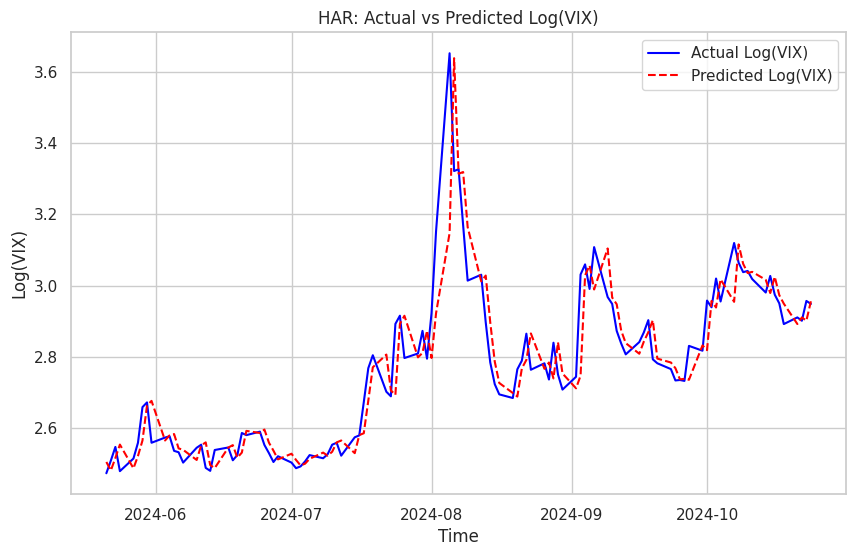

In [ ]:
# Evaluate the Model
# Compare actual vs. predicted log realized volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.index,  y_test, label='Actual Log(VIX)', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Log(VIX)', color='red', linestyle='--')
plt.title('HAR: Actual vs Predicted Log(VIX)')
plt.xlabel('Time')
plt.ylabel('Log(VIX)')
plt.legend()
plt.grid(True)
plt.show()

### HAR-GARCH

In [ ]:
from arch import arch_model

# Step 4: Extract Residuals from the HAR Model
residuals = y_train - har_model.predict(X_train)
residuals.name = "residuals"

# Step 5: Fit the GARCH Model to Residuals
garch_model = arch_model(residuals, vol='Garch', p=1, q=1, rescale=False).fit()
print("GARCH Model Summary:")
print(garch_model.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 159418878.63895968
Iteration:      2,   Func. Count:     17,   Neg. LLF: -11670.135222053734
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11670.135228393856
            Iterations: 6
            Function evaluations: 17
            Gradient evaluations: 2
GARCH Model Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                11670.1
Distribution:                  Normal   AIC:                          -23332.3
Method:            Maximum Likelihood   BIC:                          -23304.0
                                        No. Observations:                 8600
Date:                Sun, Dec 01 2024   Df Residuals:                 

In [ ]:
har_predictions_train = har_model.predict(X_train)

# Step 5: Forecast Conditional Variances on Test Set with GARCH
# Use last residual of the training set as starting point
forecast_horizon_train = len(X_train)
garch_forecast_train = garch_model.forecast(horizon=forecast_horizon_train, reindex=False)
garch_conditional_vol = garch_forecast_train.variance.values[-1]  # Get training set conditional variances

# Step 6: Combine HAR and GARCH Predictions
combined_predictions_train = har_predictions_train + np.sqrt(garch_conditional_vol)

mse_train = ((y_train - combined_predictions_train)**2).mean()
print(f"Mean Squared Error (MSE) on Training Set: {mse_train}")

# Step 1: Calculate residuals for the combined model
residuals_train = y_train - combined_predictions_train

# Step 2: Calculate SS_res (Residual Sum of Squares)
ss_res_train = np.sum(residuals_train**2)

# Step 3: Calculate SS_tot (Total Sum of Squares)
y_mean_train = np.mean(y_train)
ss_tot_train = np.sum((y_train - y_mean_train)**2)

# Step 4: Compute R^2
r_squared_train = 1 - (ss_res_train / ss_tot_train)
print(f"Combined R^2 of HAR-GARCH model: {r_squared_train}")

qlike_in_sample = qlike(y_train, combined_predictions_train)
print("In-Sample QLIKE:", qlike_in_sample)

Mean Squared Error (MSE) on Training Set: 0.008694680954089387
Combined R^2 of HAR-GARCH model: 0.9278615369678058
In-Sample QLIKE: 4.381692027101841


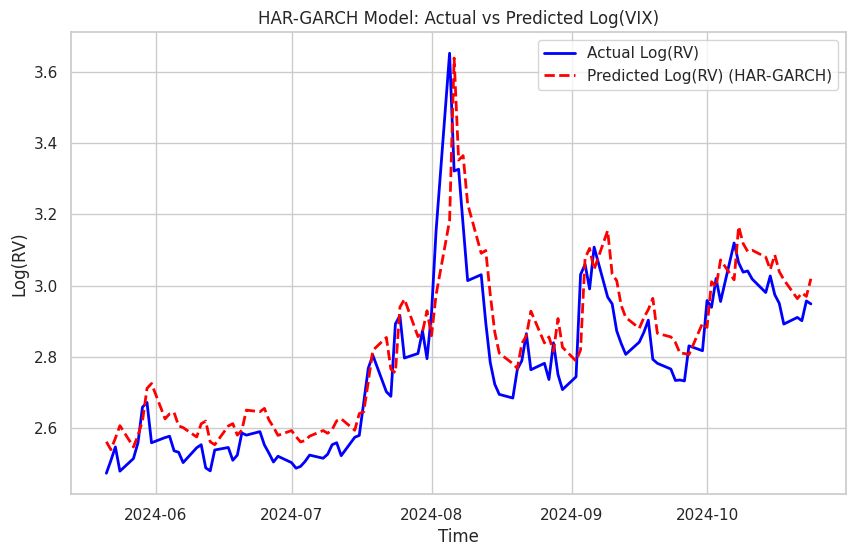

Mean Squared Error (MSE) on Test Set: 0.011812428245564069
Out-of-Sample QLIKE: 0.07626396619035658


In [ ]:
har_predictions_test = har_model.predict(X_test)

# Step 5: Forecast Conditional Variances on Test Set with GARCH
# Use last residual of the training set as starting point
forecast_horizon_test = len(X_test)
garch_forecast_test = garch_model.forecast(horizon=forecast_horizon_test, reindex=False)
garch_conditional_vol_test = garch_forecast_test.variance.values[-1]  # Get test set conditional variances

# Step 6: Combine HAR and GARCH Predictions
combined_predictions_test = har_predictions_test + np.sqrt(garch_conditional_vol_test)

# Step 7: Visualize and Evaluate
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Log(RV)', color='blue', linewidth=2)
plt.plot(y_test.index, combined_predictions_test, label='Predicted Log(RV) (HAR-GARCH)', color='red', linestyle='--', linewidth=2)
plt.title('HAR-GARCH Model: Actual vs Predicted Log(VIX)')
plt.xlabel('Time')
plt.ylabel('Log(RV)')
plt.legend()
plt.grid(True)
plt.show()

# Mean Squared Error (MSE) for Test Set
mse_test = ((y_test - combined_predictions_test)**2).mean()
print(f"Mean Squared Error (MSE) on Test Set: {mse_test}")

qlike_out_sample = qlike(y_test, combined_predictions_test)
print("Out-of-Sample QLIKE:", qlike_out_sample)


### Weighted Least Square

In [ ]:
def calculate_weights(y, window=22):  # 22 days = approximately 1 trading month
    # Calculate rolling standard deviation
    rolling_std = y.rolling(window=window).std()
    # Replace NaN with the overall std
    rolling_std = rolling_std.fillna(y.std())
    # Weights are inverse of variance (square of std)
    weights = 1 / (rolling_std ** 2)
    return weights

# Generate weights for training data
weights_train = calculate_weights(y_train)

# Train the WLS model
wls_model = sm.WLS(y_train, X_train, weights=weights_train).fit()

# Step 2: Predict on training and testing sets
y_train_pred = wls_model.predict(X_train)
y_test_pred = wls_model.predict(X_test)

# Step 3: In-Sample MSE
mse_in_sample = mean_squared_error(y_train, y_train_pred)
print("In-Sample Mean Squared Error (MSE):", mse_in_sample)

# Step 4: Out-of-Sample MSE (already provided)
mse_out_sample = mean_squared_error(y_test, y_test_pred)
print("Out-of-Sample Mean Squared Error (MSE):", mse_out_sample)

# Step 6: Compute In-Sample QLIKE
qlike_in_sample = qlike(y_train, y_train_pred)
print("In-Sample QLIKE:", qlike_in_sample)

# Step 7: Compute Out-of-Sample QLIKE
qlike_out_sample = qlike(y_test, y_test_pred)
print("Out-of-Sample QLIKE:", qlike_out_sample)


print("\nModel Summary:")
print(wls_model.summary())


In-Sample Mean Squared Error (MSE): 0.004403598179220103
Out-of-Sample Mean Squared Error (MSE): 0.008133456287378176
In-Sample QLIKE: 2.1790639557958356
Out-of-Sample QLIKE: 0.05120219651269875

Model Summary:
                            WLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.972
Model:                            WLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 1.007e+05
Date:                Sun, 01 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:41:24   Log-Likelihood:                 11506.
No. Observations:                8600   AIC:                        -2.300e+04
Df Residuals:                    8596   BIC:                        -2.298e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         

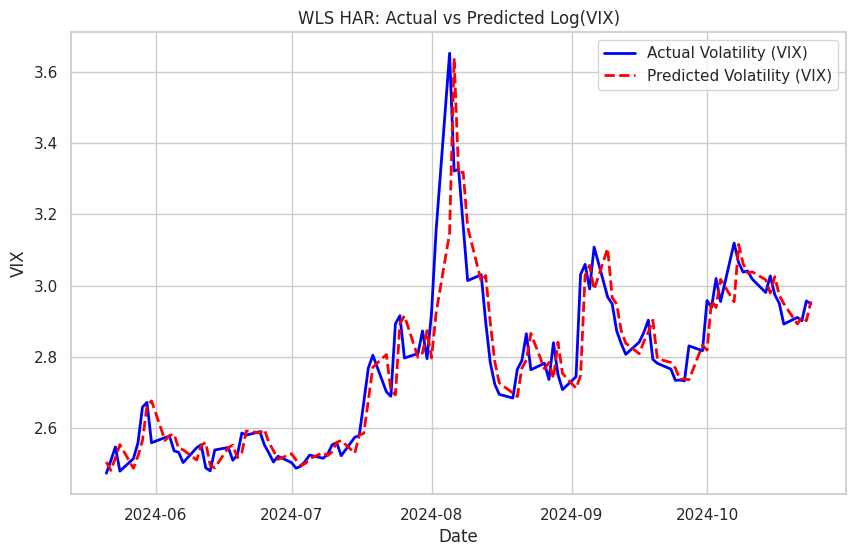

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Actual Volatility (VIX)', color='blue', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted Volatility (VIX)', color='red', linestyle='--', linewidth=2)
plt.title('WLS HAR: Actual vs Predicted Log(VIX)')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
plt.grid(True)
plt.show()

### Stationarity Check

In [ ]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

# Stationarity Check for all variables
def check_stationarity(series, name):
    result = adfuller(series)
    print(f"{name} - ADF Statistic: {result[0]:.4f}, p-value: {result[1]:.4f}")
    if result[1] > 0.05:
        print(f"{name} is non-stationary. Consider differencing.")
    else:
        print(f"{name} is stationary.")

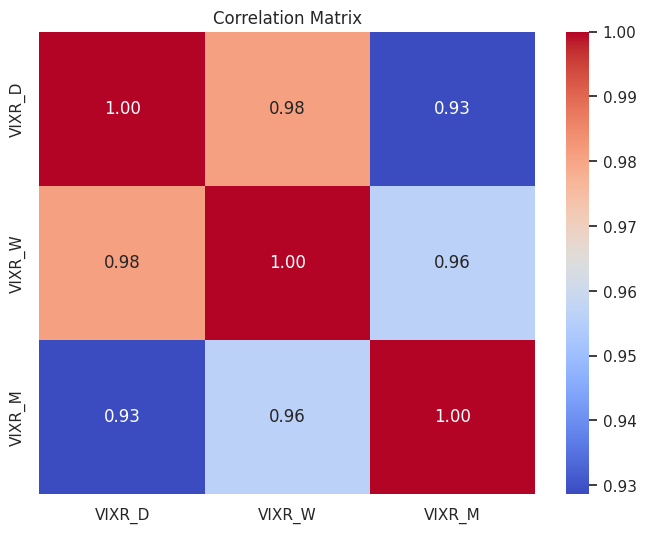

In [ ]:
import seaborn as sns
# Standardize the data
data = (X - X.mean()) / X.std()

# Check correlation between variables
correlation_matrix = data.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

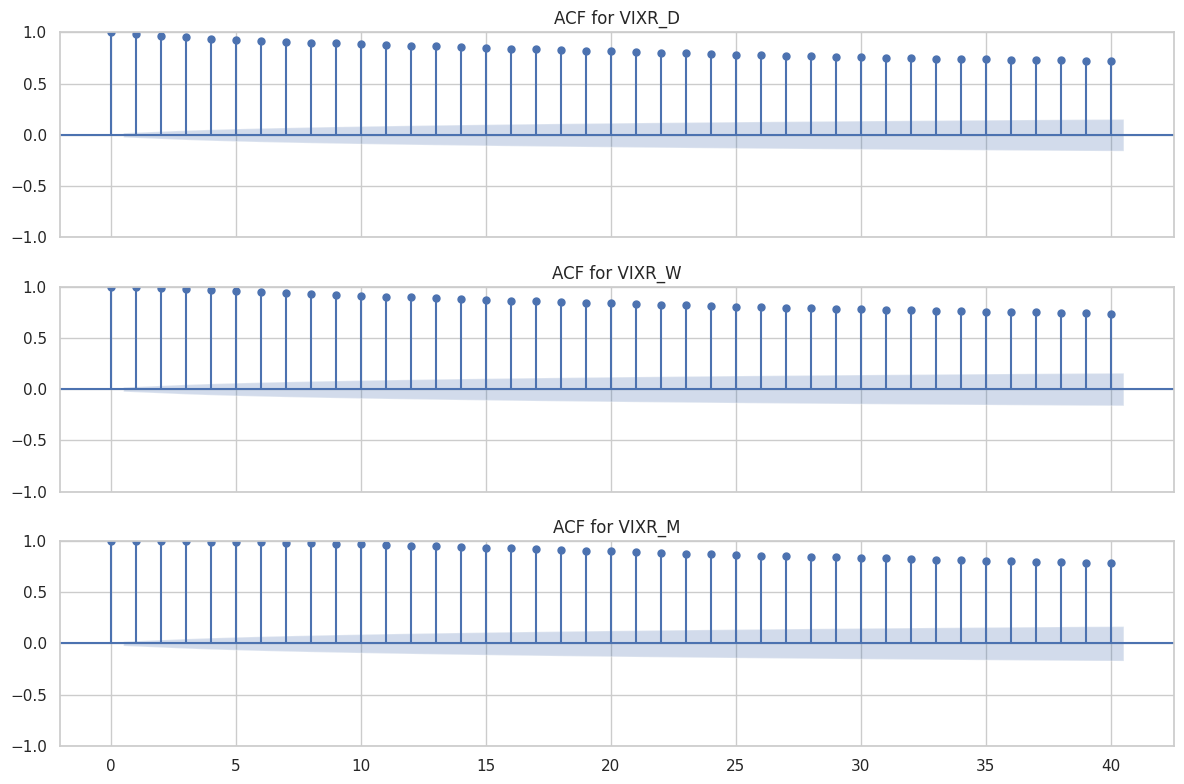

In [ ]:
# Plot ACF for VIXR+1, VIXR_W, and VIXR_M
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
for i, col in enumerate(["VIXR_D", "VIXR_W", "VIXR_M"]):
    plot_acf(data[col], ax=axes[i], title=f"ACF for {col}")
plt.tight_layout()
plt.show()
plt.show()

In [ ]:
for col in data.columns:
    check_stationarity(data[col], col)

# If any series is non-stationary, apply differencing
data_diff = data.diff().dropna()

VIXR_D - ADF Statistic: -6.2028, p-value: 0.0000
VIXR_D is stationary.
VIXR_W - ADF Statistic: -5.2338, p-value: 0.0000
VIXR_W is stationary.
VIXR_M - ADF Statistic: -4.6976, p-value: 0.0001
VIXR_M is stationary.
